# Loading libraries

In [1]:
# Libraries

# data manipulation
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import pydot
import graphviz
import pydotplus

# model creation and metrics
from tensorflow import keras
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.layers import Input, Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization
from keras.activations import relu, softmax
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical, plot_model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.model_selection import train_test_split

# other
import os
from PIL import Image
import random
from collections import Counter, OrderedDict


# EDA

In [2]:
# Loading attached .csv's to get basic info about dataset

#Train.csv contains information regarding each train image
df_train = pd.read_csv("https://raw.githubusercontent.com/imarekkus/Master-s_Thesis/main/dane/GTSRB/Train.csv")
#labels_train = df_train['ClassId']

#Test.csv contains information regarding each test image
df_test = pd.read_csv('https://raw.githubusercontent.com/imarekkus/Master-s_Thesis/main/dane/GTSRB/Test.csv')
#labels_test = df_test['ClassId']


df_train.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [3]:
# Basic info about the image shape, test and training set
print("Training Set: {} samples".format(len(df_train)))
print("Test Set:     {} samples".format(len(df_test)))

Training Set: 39209 samples
Test Set:     12630 samples


In [4]:
# Unique classes
len(np.unique(df_train['ClassId']))

43

In [5]:
# Defining function to load training dataset

def readGTSRBTrain(rootpath):

    images = [] # images
    labels = [] # corresponding labels
    
    # loop over all 42 classes
    for imgclass in range(0,43):

        # get path to folder for each class
        path = rootpath + '/' + str(imgclass)

        # get the list of images in the specified folder
        images_list = os.listdir(path)

        # iterate over the list of images
        for i in images_list:
            

            try:
                
                # open each image in the list
                image = Image.open(path + '/' + i)

                # resize each image to the same size
                image = image.resize((32,32))

                # convert it into numpy array
                image = np.array(image)

                #append images and labels
                images.append(image)
                labels.append(imgclass)

            except:

                # print error and which image it concerns
                print("ERROR loading image " + str(i))

    return images, labels


In [6]:
# Reading GTSRB train dataset

trainImages, trainLabels = readGTSRBTrain('E:/Praca Magisterska/GTSRB/Train')


In [7]:
# Reading GTSRB test dataset

def readGTSRBTest():

    # reading Test.csv to get paths to test images
    df_test = pd.read_csv('https://raw.githubusercontent.com/imarekkus/Master-s_Thesis/main/dane/GTSRB/Test.csv')

    path = df_test["Path"].values
    labels = df_test["ClassId"].values
    

    testImages=[]
    #testLabels=[]

    # iterate over the list of images path from csv
    for img in path:

        try: 
            # open each image in the folder
            image = Image.open('E:/Praca Magisterska/GTSRB/'+ img)
            
            # resize each image to the same size
            image = image.resize([32, 32])

            # convert it into numpy array
            image = np.array(image)

            #append images 
            testImages.append(image)

        except:
            print("ERROR loading image " + str(img))

    return testImages, labels


In [8]:
# Reading GTSRB test dataset

testImages, testLabels = readGTSRBTest()

In [9]:
# Checking size of both lists
print("Images and labels in train data: ")
print(len(trainLabels), len(trainImages))
print("Images in test data: ")
print(len(testLabels), len(testImages))

Images and labels in train data: 
39209 39209
Images in test data: 
12630 12630


In [10]:
# Size of images

# Combine two columns into new one called size
df_train['Size'] = df_train['Width'].astype(str) + 'x' + df_train['Height'].astype(str)
df_test['Size'] = df_test['Width'].astype(str) + 'x' + df_test['Height'].astype(str)

# Getting unique values
len(np.unique(df_train['Size']))

2924

(32, 32, 3)


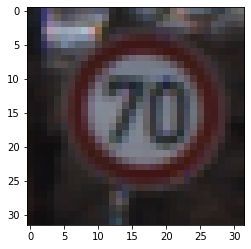

In [11]:
# Example of train image
print(trainImages[8000].shape)
plt.imshow(trainImages[8000])
plt.show()


In [12]:
# Creating table with summary of basic info
df_summary = pd.DataFrame({'Liczebność danych':['Zbiór treningowy', 'Zbiór testowy', 'Liczba klas'],
                                'Wartości':[len(trainImages), len(testImages), len(np.unique(df_train['ClassId']))]
                                })
df_summary

,Liczebność danych,Wartości
0,Zbiór treningowy,39209
1,Zbiór testowy,12630
2,Liczba klas,43


In [14]:
# Saving table to csv
#df_summary.to_csv('Podsumowanie danych.csv', encoding='utf-8-sig', index=False)

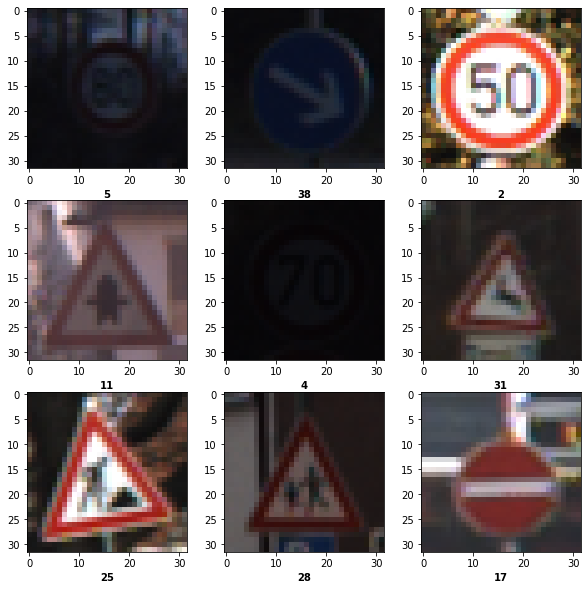

In [13]:
# Visualizing some more images

# Setting size of figure
plt.figure(figsize=(10,10))

# Setting up seed for replicability
random.seed(1)

# Loop for creating figure with images
for i in range(1,10):
    
    # Creating subplots for 10 images
    plt.subplot(3,3,i)

    # Choosing random number
    number = random.randint(0,39209)

    # Getting random image and coresponding label
    image = trainImages[number]
    label = trainLabels[number]

    # Plotting images and labels
    plt.imshow(image)
    plt.xlabel(label, fontweight='bold')

# Saving image to jpg
#plt.savefig('Images_vis.jpg', bbox_inches='tight')

In [15]:
# Balance of classes
unique_classes_train, classes_counts_train = np.unique(df_train['ClassId'], return_counts=True)

unique_classes_test, classes_counts_test = np.unique(df_test['ClassId'], return_counts=True)

In [14]:
# Corresponding labels
classes_train = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

In [16]:
# Looking at the mean number of images of classes
print("Train set mean: {:.0f}".format(classes_counts_train.mean()))
print("Train set mean: {:.0f}".format(classes_counts_test.mean()))


Train set mean: 912
Train set mean: 294


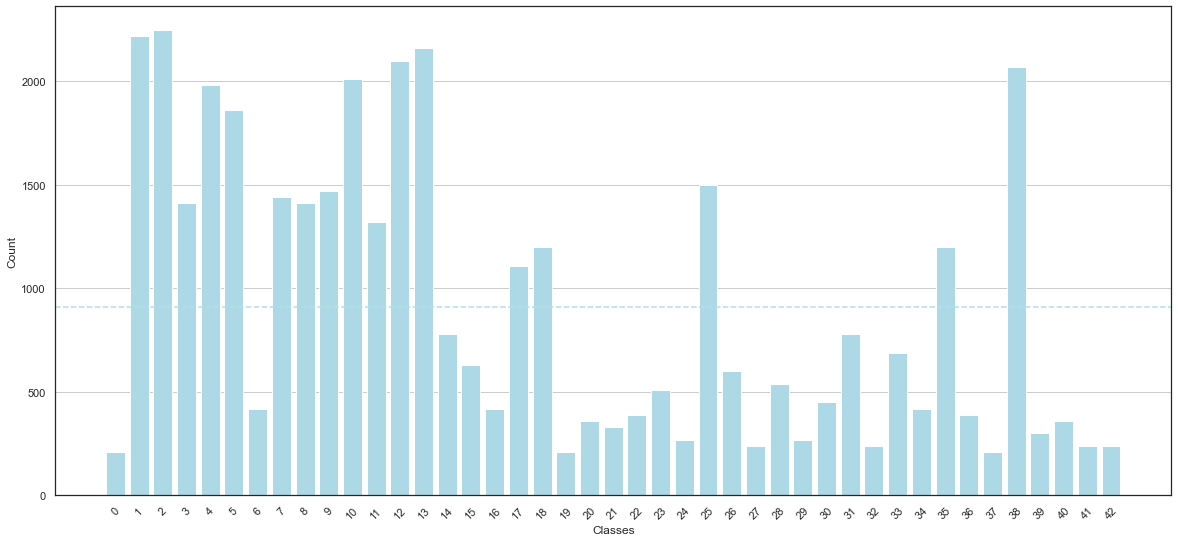

In [19]:
# Balance of classes in train set

# Setting up theme and grid look
sns.set_theme(style="white", palette="pastel")
plt.figure(figsize=(20,9))
plt.grid(axis='y')

# Plotting barplot, rotating ticks and adding mean
plt.bar(unique_classes_train, classes_counts_train, color='lightblue')
plt.xticks(unique_classes_train, rotation=45)
plt.axhline(y = classes_counts_train.mean(), linestyle='--', color='powderblue')

# Adding labels
plt.xlabel('Classes')
plt.ylabel('Count')

plt.show()

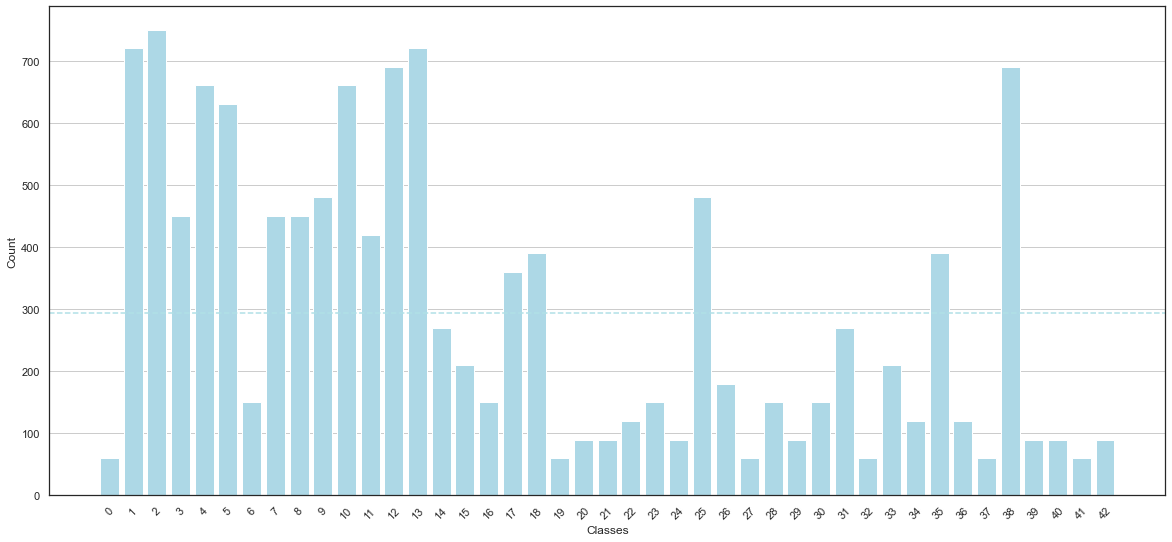

In [20]:
# Balance of classes in test set

# Setting up theme and grid look
plt.figure(figsize=(20,9))
plt.grid(axis='y')

# Plotting barplot, rotating ticks and adding mean
plt.bar(unique_classes_test, classes_counts_test, color='lightblue')
plt.xticks(unique_classes_test, rotation=45)
plt.axhline(y = classes_counts_test.mean(), linestyle='--', color='powderblue')

# Adding labels
plt.xlabel('Classes')
plt.ylabel('Count')

plt.show()

In [15]:
# Different size of images

# For train set
unique_height_train, height_counts_train = np.unique(df_train['Height'], return_counts=True)
unique_width_train, width_counts_train = np.unique(df_train['Width'], return_counts=True)

# and for test set
unique_height_test, height_counts_test = np.unique(df_test['Height'], return_counts=True)
unique_width_test, width_counts_test = np.unique(df_test['Width'], return_counts=True)


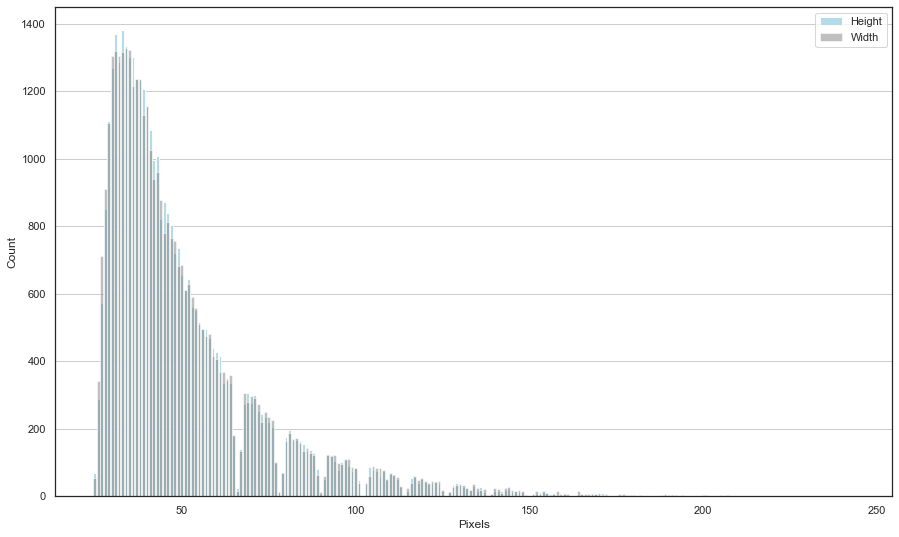

In [22]:
# Different size of images in train set

# Setting up theme and grid look
plt.figure(figsize=(15,9))
plt.grid(axis='y')

# Plotting barplot 
plt.bar(unique_height_train, height_counts_train, color='lightblue', alpha=0.9, label='Height')
plt.bar(unique_width_train, width_counts_train, color='grey', alpha=0.5, label='Width')

# and adding mean
#plt.axhline(y = height_counts_train.mean(), linestyle='--', color='powderblue')
#plt.axhline(y = width_counts_train.mean(), linestyle='--', color='grey')

# adding labels and legend
plt.xlabel('Pixels')
plt.ylabel('Count')
plt.legend(loc='upper right')

plt.show()

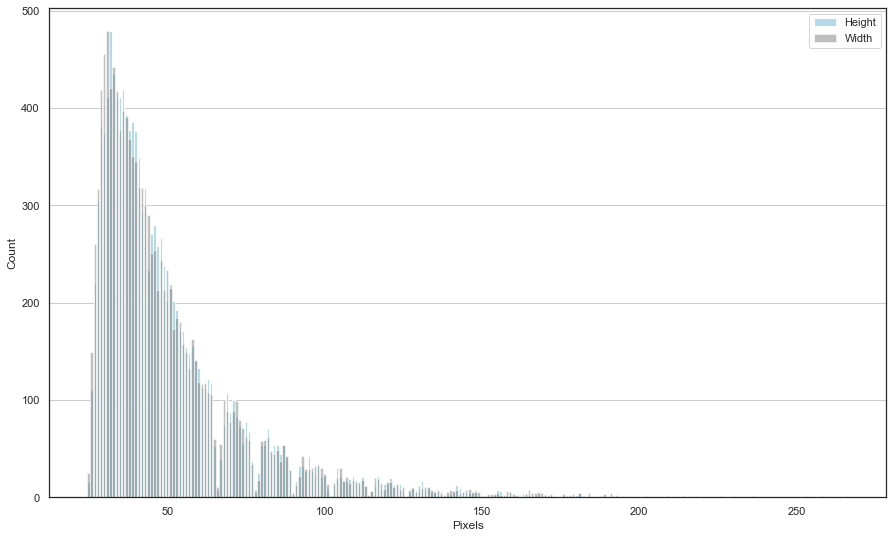

In [23]:
# Different size of images in test set

# Setting up theme and grid look
plt.figure(figsize=(15,9))
plt.grid(axis='y')

# Plotting barplot 
plt.bar(unique_height_test, height_counts_test, color='lightblue', alpha=0.9, label='Height')
plt.bar(unique_width_test, width_counts_test, color='grey', alpha=0.5, label='Width')

# and adding mean
#plt.axhline(y = unique_height_test.mean(), linestyle='--', color='powderblue')
#plt.axhline(y = width_counts_test.mean(), linestyle='--', color='grey')

# adding labels and legend
plt.xlabel('Pixels')
plt.ylabel('Count')
plt.legend(loc='upper right')

plt.show()

# Preparing data

In [17]:
# Converting data into numpy arrays
X_train = np.array(trainImages)
y_train = np.array(trainLabels)

X_test = np.array(testImages)
y_test = np.array(testLabels)

In [18]:
X_train[8000].shape

(32, 32, 3)

In [19]:
# One hot encoding for labels
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)

# Model without augmentations

## Dense neural networks

### Neural network - 2 dense layers

In [60]:
model = Sequential()
model.add(Flatten(input_shape=X_train.shape[1:]))
model.add(Dense(32, activation='relu'))
model.add(Dense(43, activation='softmax'))
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_11 (Flatten)        (None, 3072)              0         
                                                                 
 dense_48 (Dense)            (None, 32)                98336     
                                                                 
 dense_49 (Dense)            (None, 43)                1419      
                                                                 
Total params: 99,755
Trainable params: 99,755
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20


C:\Users\PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


307/307 [==============================] - 1s 3ms/step - loss: 4.5527 - accuracy: 0.0567 - val_loss: 3.6364 - val_accuracy: 0.0570
Epoch 2/20
307/307 [==============================] - 1s 4ms/step - loss: 3.6019 - accuracy: 0.0559 - val_loss: 3.5586 - val_accuracy: 0.0570
Epoch 3/20
307/307 [==============================] - 1s 4ms/step - loss: 3.5468 - accuracy: 0.0558 - val_loss: 3.5154 - val_accuracy: 0.0570
Epoch 4/20
307/307 [==============================] - 1s 3ms/step - loss: 3.5173 - accuracy: 0.0565 - val_loss: 3.4919 - val_accuracy: 0.0594
Epoch 5/20
307/307 [==============================] - 1s 4ms/step - loss: 3.5020 - accuracy: 0.0551 - val_loss: 3.4793 - val_accuracy: 0.0594
Epoch 6/20
307/307 [==============================] - 1s 4ms/step - loss: 3.4942 - accuracy: 0.0569 - val_loss: 3.4723 - val_accuracy: 0.0594
Epoch 7/20
307/307 [==============================] - 1s 4ms/step - loss: 3.4902 - accuracy: 0.0569 - val_loss: 3.4686 - val_accuracy: 0.0594
Epoch 8/20
307/30

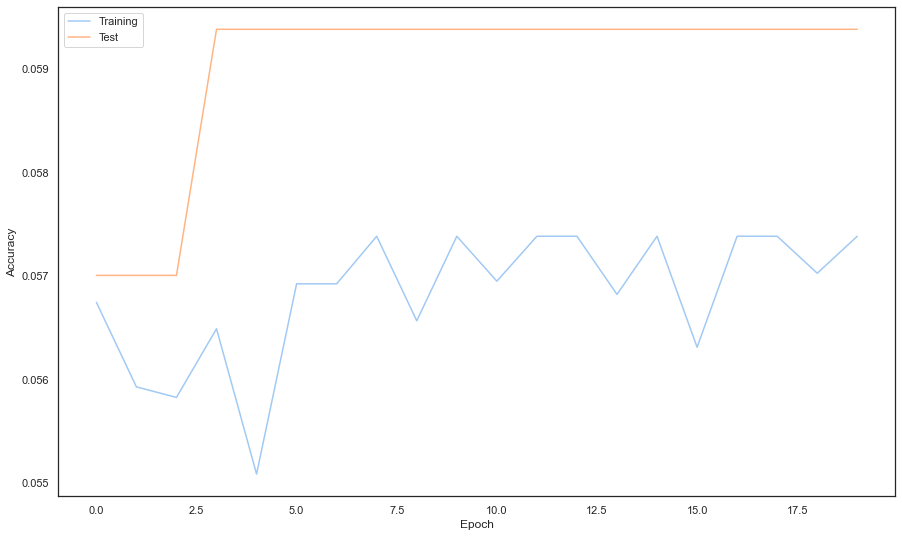

In [61]:
# Setting up parameters
epochs = 20
batch_size = 128
opt_adam = Adam(lr = 0.001)

# Compiling model
model.compile(
    loss = 'categorical_crossentropy', 
    optimizer = opt_adam, 
    metrics = ['accuracy']
);

# Training model
model_history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data = (X_test, y_test))

# Predicting on test data
y_predict = np.argmax(model.predict(X_test), axis=1)

# Checking accuracy on test data
print('\n Test accuracy: ')
print(accuracy_score(np.array(testLabels), y_predict))

# Setting up size of plot and theme
sns.set_theme(style="white", palette="pastel")
plt.figure(figsize=(15,9))

# Plotting accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])

# Setting up labels
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# and legend
plt.legend(['Training', 'Test'], loc='upper left')

plt.show()

### Neural network - 4 dense layers

In [62]:
model = Sequential()
model.add(Flatten(input_shape=X_train.shape[1:]))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(43, activation='softmax'))
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_12 (Flatten)        (None, 3072)              0         
                                                                 
 dense_50 (Dense)            (None, 32)                98336     
                                                                 
 dense_51 (Dense)            (None, 64)                2112      
                                                                 
 dense_52 (Dense)            (None, 128)               8320      
                                                                 
 dense_53 (Dense)            (None, 43)                5547      
                                                                 
Total params: 114,315
Trainable params: 114,315
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20


C:\Users\PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


307/307 [==============================] - 2s 4ms/step - loss: 4.6825 - accuracy: 0.0516 - val_loss: 3.4643 - val_accuracy: 0.0546
Epoch 2/20
307/307 [==============================] - 1s 4ms/step - loss: 3.4868 - accuracy: 0.0561 - val_loss: 3.4634 - val_accuracy: 0.0594
Epoch 3/20
307/307 [==============================] - 1s 4ms/step - loss: 3.4867 - accuracy: 0.0564 - val_loss: 3.4635 - val_accuracy: 0.0570
Epoch 4/20
307/307 [==============================] - 1s 4ms/step - loss: 3.4868 - accuracy: 0.0571 - val_loss: 3.4635 - val_accuracy: 0.0594
Epoch 5/20
307/307 [==============================] - 1s 4ms/step - loss: 3.4865 - accuracy: 0.0560 - val_loss: 3.4638 - val_accuracy: 0.0570
Epoch 6/20
307/307 [==============================] - 1s 4ms/step - loss: 3.4868 - accuracy: 0.0570 - val_loss: 3.4626 - val_accuracy: 0.0594
Epoch 7/20
307/307 [==============================] - 1s 4ms/step - loss: 3.4868 - accuracy: 0.0558 - val_loss: 3.4636 - val_accuracy: 0.0594
Epoch 8/20
307/30

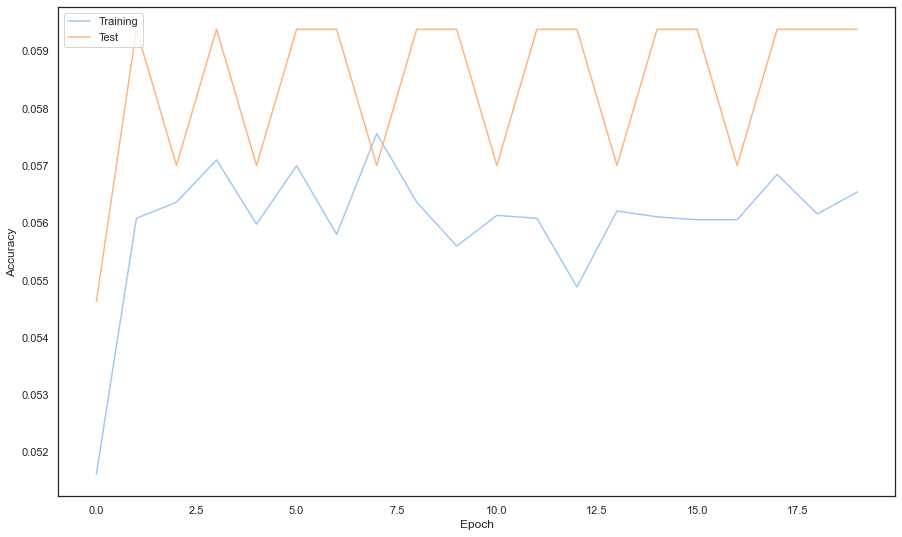

In [63]:
# Setting up parameters
epochs = 20
batch_size = 128
opt_adam = Adam(lr = 0.001)

# Compiling model
model.compile(
    loss = 'categorical_crossentropy', 
    optimizer = opt_adam, 
    metrics = ['accuracy']
);

# Training model
model_history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data = (X_test, y_test))

# Predicting on test data
y_predict = np.argmax(model.predict(X_test), axis=1)

# Checking accuracy on test data
print('\n Test accuracy: ')
print(accuracy_score(np.array(testLabels), y_predict))

# Setting up size of plot and theme
sns.set_theme(style="white", palette="pastel")
plt.figure(figsize=(15,9))

# Plotting accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])

# Setting up labels
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# and legend
plt.legend(['Training', 'Test'], loc='upper left')

plt.show()

## Convolutional models

#### CNN - 1 conv layer

In [85]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=X_train.shape[1:]))

model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(43, activation='softmax'))

model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 flatten_24 (Flatten)        (None, 28800)             0         
                                                                 
 dense_86 (Dense)            (None, 32)                921632    
                                                                 
 dense_87 (Dense)            (None, 64)                2112      
                                                                 
 dense_88 (Dense)            (None, 128)               8320      
                                                                 
 dense_89 (Dense)            (None, 43)                5547      
                                                                 
Total params: 938,507
Trainable params: 938,507
Non-t

Epoch 1/20
307/307 [==============================] - 9s 28ms/step - loss: 7.2734 - accuracy: 0.0559 - val_loss: 3.4660 - val_accuracy: 0.0594
Epoch 2/20
307/307 [==============================] - 8s 27ms/step - loss: 3.4873 - accuracy: 0.0563 - val_loss: 3.4629 - val_accuracy: 0.0594
Epoch 3/20
307/307 [==============================] - 8s 27ms/step - loss: 3.4869 - accuracy: 0.0555 - val_loss: 3.4631 - val_accuracy: 0.0594
Epoch 4/20
307/307 [==============================] - 8s 27ms/step - loss: 3.4869 - accuracy: 0.0569 - val_loss: 3.4629 - val_accuracy: 0.0570
Epoch 5/20
307/307 [==============================] - 8s 28ms/step - loss: 3.4867 - accuracy: 0.0571 - val_loss: 3.4639 - val_accuracy: 0.0594
Epoch 6/20
307/307 [==============================] - 8s 27ms/step - loss: 3.4867 - accuracy: 0.0558 - val_loss: 3.4629 - val_accuracy: 0.0594
Epoch 7/20
307/307 [==============================] - 8s 27ms/step - loss: 3.4867 - accuracy: 0.0565 - val_loss: 3.4640 - val_accuracy: 0.0570

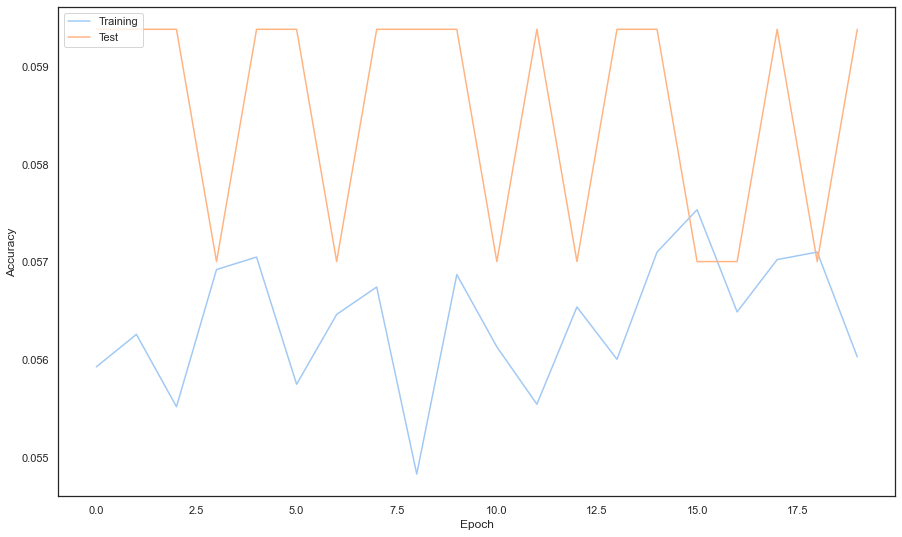

In [77]:
# Setting up parameters
epochs = 20
batch_size = 128
opt_adam = Adam(lr = 0.001)

# Compiling model
model.compile(
    loss = 'categorical_crossentropy', 
    optimizer = opt_adam, 
    metrics = ['accuracy']
);

# Training model
model_history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data = (X_test, y_test))

# Predicting on test data
y_predict = np.argmax(model.predict(X_test), axis=1)

# Checking accuracy on test data
print('\n Test accuracy: ')
print(accuracy_score(np.array(testLabels), y_predict))

# Setting up size of plot and theme
sns.set_theme(style="white", palette="pastel")
plt.figure(figsize=(15,9))

# Plotting accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])

# Setting up labels
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# and legend
plt.legend(['Training', 'Test'], loc='upper left')

plt.show()

#### CNN - 1 conv layer less dense layers

In [86]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=X_train.shape[1:]))

model.add(Flatten())
model.add(Dense(43, activation='softmax'))

model.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 flatten_25 (Flatten)        (None, 28800)             0         
                                                                 
 dense_90 (Dense)            (None, 43)                1238443   
                                                                 
Total params: 1,239,339
Trainable params: 1,239,339
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20


C:\Users\PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


307/307 [==============================] - 11s 34ms/step - loss: 34.9687 - accuracy: 0.6977 - val_loss: 1.6776 - val_accuracy: 0.7685
Epoch 2/20
307/307 [==============================] - 11s 35ms/step - loss: 0.3267 - accuracy: 0.9277 - val_loss: 1.7392 - val_accuracy: 0.7890
Epoch 3/20
307/307 [==============================] - 11s 36ms/step - loss: 0.2044 - accuracy: 0.9528 - val_loss: 1.9276 - val_accuracy: 0.8223
Epoch 4/20
307/307 [==============================] - 11s 37ms/step - loss: 0.1433 - accuracy: 0.9668 - val_loss: 1.9255 - val_accuracy: 0.8261
Epoch 5/20
307/307 [==============================] - 11s 34ms/step - loss: 0.1228 - accuracy: 0.9730 - val_loss: 2.1196 - val_accuracy: 0.8356
Epoch 6/20
307/307 [==============================] - 11s 34ms/step - loss: 0.1112 - accuracy: 0.9760 - val_loss: 2.2789 - val_accuracy: 0.8301
Epoch 7/20
307/307 [==============================] - 10s 33ms/step - loss: 0.1072 - accuracy: 0.9763 - val_loss: 2.8855 - val_accuracy: 0.8197
Ep

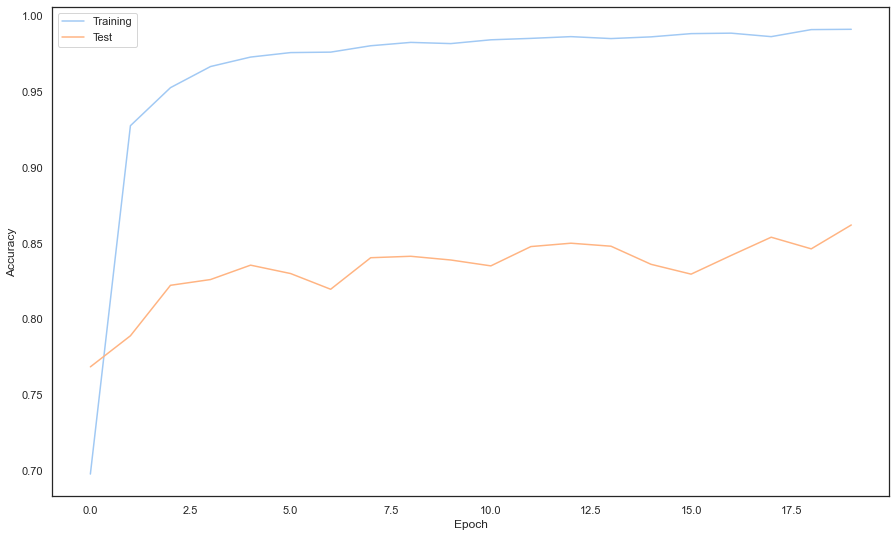

In [87]:
# Setting up parameters
epochs = 20
batch_size = 128
opt_adam = Adam(lr = 0.001)

# Compiling model
model.compile(
    loss = 'categorical_crossentropy', 
    optimizer = opt_adam, 
    metrics = ['accuracy']
);

# Training model
model_history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data = (X_test, y_test))

# Predicting on test data
y_predict = np.argmax(model.predict(X_test), axis=1)

# Checking accuracy on test data
print('\n Test accuracy: ')
print(accuracy_score(np.array(testLabels), y_predict))

# Setting up size of plot and theme
sns.set_theme(style="white", palette="pastel")
plt.figure(figsize=(15,9))

# Plotting accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])

# Setting up labels
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# and legend
plt.legend(['Training', 'Test'], loc='upper left')

plt.show()

#### CNN - 1 conv layer + maxpool 

In [83]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=X_train.shape[1:]))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(43, activation='softmax'))

model.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 flatten_23 (Flatten)        (None, 7200)              0         
                                                                 
 dense_85 (Dense)            (None, 43)                309643    
                                                                 
Total params: 310,539
Trainable params: 310,539
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20


C:\Users\PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


307/307 [==============================] - 11s 34ms/step - loss: 14.3304 - accuracy: 0.7144 - val_loss: 1.0851 - val_accuracy: 0.8219
Epoch 2/20
307/307 [==============================] - 10s 33ms/step - loss: 0.2598 - accuracy: 0.9426 - val_loss: 1.0573 - val_accuracy: 0.8462
Epoch 3/20
307/307 [==============================] - 11s 34ms/step - loss: 0.1438 - accuracy: 0.9667 - val_loss: 1.0831 - val_accuracy: 0.8679
Epoch 4/20
307/307 [==============================] - 10s 33ms/step - loss: 0.1108 - accuracy: 0.9738 - val_loss: 1.3142 - val_accuracy: 0.8609
Epoch 5/20
307/307 [==============================] - 10s 33ms/step - loss: 0.1142 - accuracy: 0.9751 - val_loss: 1.2478 - val_accuracy: 0.8745
Epoch 6/20
307/307 [==============================] - 10s 32ms/step - loss: 0.0917 - accuracy: 0.9796 - val_loss: 1.2529 - val_accuracy: 0.8754
Epoch 7/20
307/307 [==============================] - 11s 35ms/step - loss: 0.0935 - accuracy: 0.9791 - val_loss: 1.3833 - val_accuracy: 0.8713
Ep

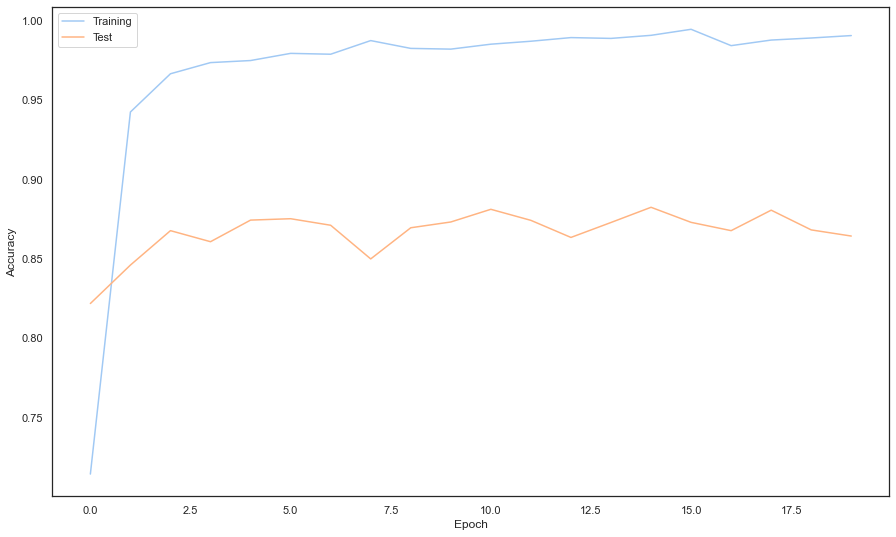

In [84]:
# Setting up parameters
epochs = 20
batch_size = 128
opt_adam = Adam(lr = 0.001)

# Compiling model
model.compile(
    loss = 'categorical_crossentropy', 
    optimizer = opt_adam, 
    metrics = ['accuracy']
);

# Training model
model_history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data = (X_test, y_test))

# Predicting on test data
y_predict = np.argmax(model.predict(X_test), axis=1)

# Checking accuracy on test data
print('\n Test accuracy: ')
print(accuracy_score(np.array(testLabels), y_predict))

# Setting up size of plot and theme
sns.set_theme(style="white", palette="pastel")
plt.figure(figsize=(15,9))

# Plotting accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])

# Setting up labels
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# and legend
plt.legend(['Training', 'Test'], loc='upper left')

plt.show()

#### CNN - 1 conv layer + maxpool + dropout

In [89]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=X_train.shape[1:]))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(43, activation='softmax'))

model.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 15, 15, 32)        0         
                                                                 
 flatten_26 (Flatten)        (None, 7200)              0         
                                                                 
 dense_91 (Dense)            (None, 43)                309643    
                                                                 
Total params: 310,539
Trainable params: 310,539
Non-trainable params: 0
_______________________________________________

Epoch 1/20


C:\Users\PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


307/307 [==============================] - 14s 43ms/step - loss: 7.3258 - accuracy: 0.6949 - val_loss: 1.0954 - val_accuracy: 0.8190
Epoch 2/20
307/307 [==============================] - 12s 40ms/step - loss: 0.3768 - accuracy: 0.9126 - val_loss: 1.1137 - val_accuracy: 0.8549
Epoch 3/20
307/307 [==============================] - 12s 40ms/step - loss: 0.2635 - accuracy: 0.9401 - val_loss: 1.2216 - val_accuracy: 0.8501
Epoch 4/20
307/307 [==============================] - 13s 41ms/step - loss: 0.2341 - accuracy: 0.9467 - val_loss: 1.2472 - val_accuracy: 0.8640
Epoch 5/20
307/307 [==============================] - 12s 39ms/step - loss: 0.2034 - accuracy: 0.9536 - val_loss: 1.3705 - val_accuracy: 0.8685
Epoch 6/20
307/307 [==============================] - 13s 41ms/step - loss: 0.2024 - accuracy: 0.9572 - val_loss: 1.5354 - val_accuracy: 0.8689
Epoch 7/20
307/307 [==============================] - 12s 39ms/step - loss: 0.1840 - accuracy: 0.9593 - val_loss: 1.3554 - val_accuracy: 0.8759
Epo

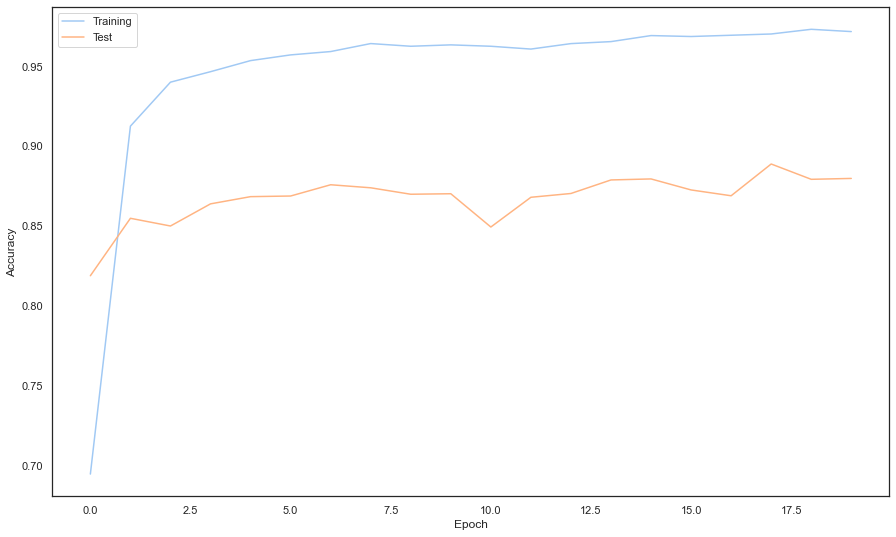

In [90]:
# Setting up parameters
epochs = 20
batch_size = 128
opt_adam = Adam(lr = 0.001)

# Compiling model
model.compile(
    loss = 'categorical_crossentropy', 
    optimizer = opt_adam, 
    metrics = ['accuracy']
);

# Training model
model_history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data = (X_test, y_test))

# Predicting on test data
y_predict = np.argmax(model.predict(X_test), axis=1)

# Checking accuracy on test data
print('\n Test accuracy: ')
print(accuracy_score(np.array(testLabels), y_predict))

# Setting up size of plot and theme
sns.set_theme(style="white", palette="pastel")
plt.figure(figsize=(15,9))

# Plotting accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])

# Setting up labels
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# and legend
plt.legend(['Training', 'Test'], loc='upper left')

plt.show()

#### CNN - 2 conv layer + 1 maxpool + 1 dropout + dense

In [103]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=X_train.shape[1:]))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))

model.add(Flatten())

model.add(Dense(43, activation='softmax'))

model.summary()

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 dropout_23 (Dropout)        (None, 15, 15, 32)        0         
                                                                 
 conv2d_31 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 flatten_35 (Flatten)        (None, 10816)             0         
                                                                 
 dense_102 (Dense)           (None, 43)                465131    
                                                     

Epoch 1/20
307/307 [==============================] - 20s 63ms/step - loss: 3.3039 - accuracy: 0.5521 - val_loss: 0.8795 - val_accuracy: 0.7922
Epoch 2/20
307/307 [==============================] - 19s 62ms/step - loss: 0.3802 - accuracy: 0.8972 - val_loss: 0.6834 - val_accuracy: 0.8582
Epoch 3/20
307/307 [==============================] - 19s 63ms/step - loss: 0.2199 - accuracy: 0.9411 - val_loss: 0.6125 - val_accuracy: 0.8814
Epoch 4/20
307/307 [==============================] - 19s 63ms/step - loss: 0.1557 - accuracy: 0.9579 - val_loss: 0.6527 - val_accuracy: 0.8932
Epoch 5/20
307/307 [==============================] - 19s 62ms/step - loss: 0.1153 - accuracy: 0.9683 - val_loss: 0.6017 - val_accuracy: 0.8960
Epoch 6/20
307/307 [==============================] - 19s 62ms/step - loss: 0.0959 - accuracy: 0.9729 - val_loss: 0.6879 - val_accuracy: 0.8923
Epoch 7/20
307/307 [==============================] - 19s 61ms/step - loss: 0.0950 - accuracy: 0.9757 - val_loss: 0.6914 - val_accuracy:

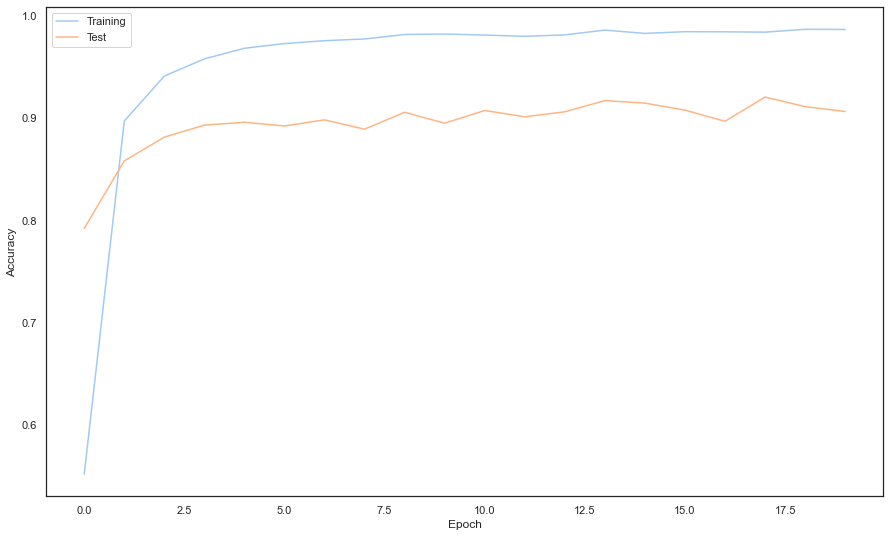

In [104]:
# Setting up parameters
epochs = 20
batch_size = 128
opt_adam = Adam(lr = 0.001)

# Compiling model
model.compile(
    loss = 'categorical_crossentropy', 
    optimizer = opt_adam, 
    metrics = ['accuracy']
);

# Training model
model_history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data = (X_test, y_test))

# Predicting on test data
y_predict = np.argmax(model.predict(X_test), axis=1)

# Checking accuracy on test data
print('\n Test accuracy: ')
print(accuracy_score(np.array(testLabels), y_predict))

# Setting up size of plot and theme
sns.set_theme(style="white", palette="pastel")
plt.figure(figsize=(15,9))

# Plotting accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])

# Setting up labels
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# and legend
plt.legend(['Training', 'Test'], loc='upper left')

plt.show()

#### CNN - 2 conv layer + 2 maxpool + 2 dropout + dense

In [105]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=X_train.shape[1:]))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(43, activation='softmax'))

model.summary()

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 15, 15, 32)        0         
                                                                 
 conv2d_33 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 dropout_25 (Dropout)        (None, 6, 6, 64)        

Epoch 1/20


C:\Users\PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


307/307 [==============================] - 21s 67ms/step - loss: 5.1868 - accuracy: 0.2606 - val_loss: 1.3147 - val_accuracy: 0.6423
Epoch 2/20
307/307 [==============================] - 19s 62ms/step - loss: 1.0739 - accuracy: 0.6867 - val_loss: 0.7880 - val_accuracy: 0.7946
Epoch 3/20
307/307 [==============================] - 18s 59ms/step - loss: 0.7049 - accuracy: 0.7968 - val_loss: 0.5505 - val_accuracy: 0.8615
Epoch 4/20
307/307 [==============================] - 19s 63ms/step - loss: 0.4759 - accuracy: 0.8621 - val_loss: 0.4355 - val_accuracy: 0.8917
Epoch 5/20
307/307 [==============================] - 22s 71ms/step - loss: 0.3557 - accuracy: 0.8986 - val_loss: 0.3935 - val_accuracy: 0.9049
Epoch 6/20
307/307 [==============================] - 22s 71ms/step - loss: 0.2946 - accuracy: 0.9176 - val_loss: 0.3449 - val_accuracy: 0.9174
Epoch 7/20
307/307 [==============================] - 23s 74ms/step - loss: 0.2339 - accuracy: 0.9348 - val_loss: 0.3241 - val_accuracy: 0.9253
Epo

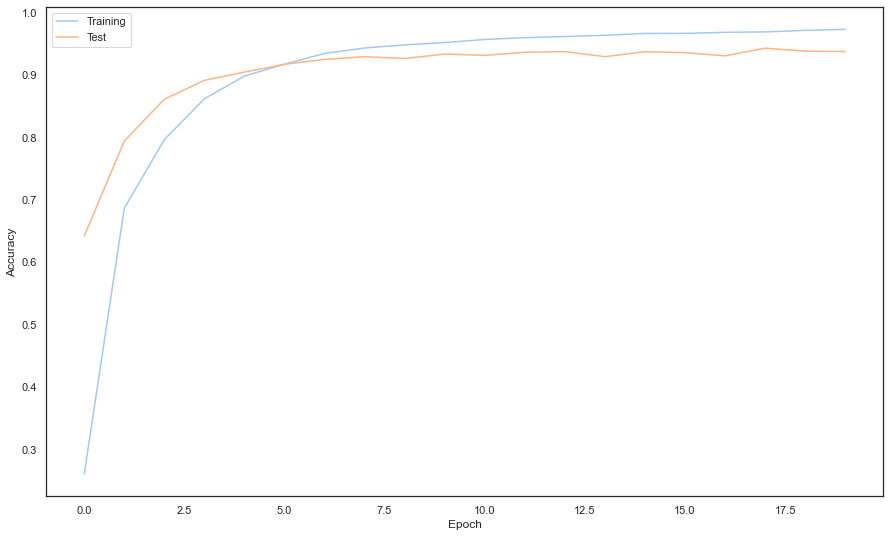

In [106]:
# Setting up parameters
epochs = 20
batch_size = 128
opt_adam = Adam(lr = 0.001)

# Compiling model
model.compile(
    loss = 'categorical_crossentropy', 
    optimizer = opt_adam, 
    metrics = ['accuracy']
);

# Training model
model_history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data = (X_test, y_test))

# Predicting on test data
y_predict = np.argmax(model.predict(X_test), axis=1)

# Checking accuracy on test data
print('\n Test accuracy: ')
print(accuracy_score(np.array(testLabels), y_predict))

# Setting up size of plot and theme
sns.set_theme(style="white", palette="pastel")
plt.figure(figsize=(15,9))

# Plotting accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])

# Setting up labels
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# and legend
plt.legend(['Training', 'Test'], loc='upper left')

plt.show()

#### CNN - 2 conv layer + 2 maxpool + 3 dropout + 2 dense

In [107]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=X_train.shape[1:]))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.3))

model.add(Dense(43, activation='softmax'))

model.summary()


Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 dropout_26 (Dropout)        (None, 15, 15, 32)        0         
                                                                 
 conv2d_35 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 dropout_27 (Dropout)        (None, 6, 6, 64)        

Epoch 1/20


C:\Users\PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


307/307 [==============================] - 19s 62ms/step - loss: 4.8994 - accuracy: 0.0578 - val_loss: 3.5613 - val_accuracy: 0.0846
Epoch 2/20
307/307 [==============================] - 19s 61ms/step - loss: 3.4893 - accuracy: 0.0872 - val_loss: 3.3387 - val_accuracy: 0.1100
Epoch 3/20
307/307 [==============================] - 19s 63ms/step - loss: 3.1359 - accuracy: 0.1637 - val_loss: 2.7997 - val_accuracy: 0.2391
Epoch 4/20
307/307 [==============================] - 19s 61ms/step - loss: 2.6647 - accuracy: 0.2410 - val_loss: 2.0303 - val_accuracy: 0.3702
Epoch 5/20
307/307 [==============================] - 19s 63ms/step - loss: 2.1256 - accuracy: 0.3652 - val_loss: 1.5182 - val_accuracy: 0.5625
Epoch 6/20
307/307 [==============================] - 19s 61ms/step - loss: 1.6479 - accuracy: 0.4771 - val_loss: 1.0802 - val_accuracy: 0.6667
Epoch 7/20
307/307 [==============================] - 19s 61ms/step - loss: 1.2150 - accuracy: 0.6105 - val_loss: 0.6885 - val_accuracy: 0.7977
Epo

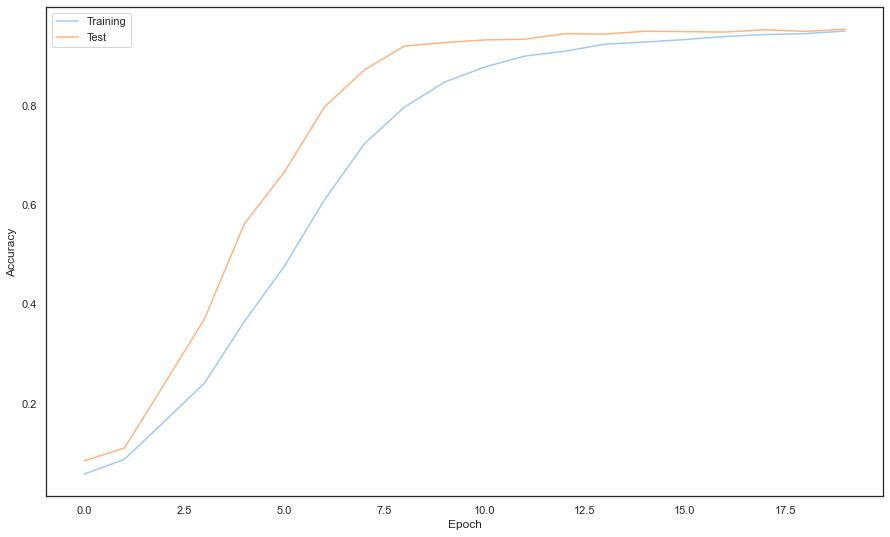

In [108]:
# Setting up parameters
epochs = 20
batch_size = 128
opt_adam = Adam(lr = 0.001)

# Compiling model
model.compile(
    loss = 'categorical_crossentropy', 
    optimizer = opt_adam, 
    metrics = ['accuracy']
);

# Training model
model_history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data = (X_test, y_test))

# Predicting on test data
y_predict = np.argmax(model.predict(X_test), axis=1)

# Checking accuracy on test data
print('\n Test accuracy: ')
print(accuracy_score(np.array(testLabels), y_predict))

# Setting up size of plot and theme
sns.set_theme(style="white", palette="pastel")
plt.figure(figsize=(15,9))

# Plotting accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])

# Setting up labels
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# and legend
plt.legend(['Training', 'Test'], loc='upper left')

plt.show()

#### CNN - 2 conv layer + 2 maxpool + 3 dropout + 2 dense + batchnorm

In [109]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=X_train.shape[1:]))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.3))

model.add(Dense(43, activation='softmax'))

model.summary()


Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization (BatchN  (None, 15, 15, 32)       128       
 ormalization)                                                   
                                                                 
 dropout_29 (Dropout)        (None, 15, 15, 32)        0         
                                                                 
 conv2d_37 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 6, 6, 64)       

Epoch 1/20


C:\Users\PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


307/307 [==============================] - 24s 74ms/step - loss: 1.0379 - accuracy: 0.7305 - val_loss: 0.3623 - val_accuracy: 0.9124
Epoch 2/20
307/307 [==============================] - 25s 81ms/step - loss: 0.1990 - accuracy: 0.9501 - val_loss: 0.2033 - val_accuracy: 0.9470
Epoch 3/20
307/307 [==============================] - 26s 83ms/step - loss: 0.1041 - accuracy: 0.9732 - val_loss: 0.1745 - val_accuracy: 0.9508
Epoch 4/20
307/307 [==============================] - 26s 85ms/step - loss: 0.0725 - accuracy: 0.9815 - val_loss: 0.1522 - val_accuracy: 0.9557
Epoch 5/20
307/307 [==============================] - 25s 81ms/step - loss: 0.0525 - accuracy: 0.9860 - val_loss: 0.1319 - val_accuracy: 0.9610
Epoch 6/20
307/307 [==============================] - 25s 80ms/step - loss: 0.0432 - accuracy: 0.9890 - val_loss: 0.1664 - val_accuracy: 0.9544
Epoch 7/20
307/307 [==============================] - 23s 74ms/step - loss: 0.0360 - accuracy: 0.9900 - val_loss: 0.1182 - val_accuracy: 0.9663
Epo

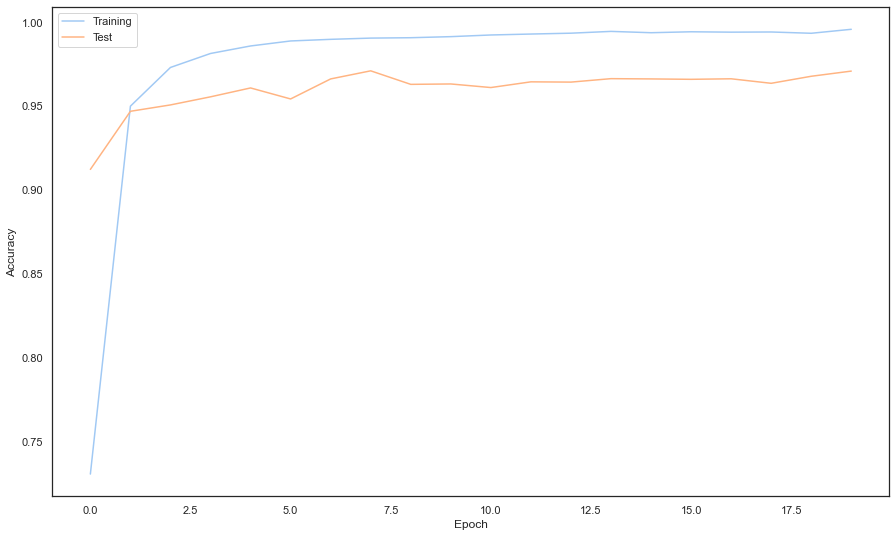

In [110]:
# Setting up parameters
epochs = 20
batch_size = 128
opt_adam = Adam(lr = 0.001)

# Compiling model
model.compile(
    loss = 'categorical_crossentropy', 
    optimizer = opt_adam, 
    metrics = ['accuracy']
);

# Training model
model_history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data = (X_test, y_test))

# Predicting on test data
y_predict = np.argmax(model.predict(X_test), axis=1)

# Checking accuracy on test data
print('\n Test accuracy: ')
print(accuracy_score(np.array(testLabels), y_predict))

# Setting up size of plot and theme
sns.set_theme(style="white", palette="pastel")
plt.figure(figsize=(15,9))

# Plotting accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])

# Setting up labels
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# and legend
plt.legend(['Training', 'Test'], loc='upper left')

plt.show()

#### CNN - 3 conv layer + 2 maxpool + 3 dropout + 2 dense + batchnorm

In [111]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(rate=0.3))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(rate=0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.3))

model.add(Dense(43, activation='softmax'))

model.summary()

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 conv2d_39 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 batch_normalization_3 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                                 
 dropout_32 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 conv2d_40 (Conv2D)          (None, 12, 12, 64)      

Epoch 1/20


C:\Users\PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


307/307 [==============================] - 66s 212ms/step - loss: 0.8968 - accuracy: 0.7783 - val_loss: 0.2176 - val_accuracy: 0.9507
Epoch 2/20
307/307 [==============================] - 64s 208ms/step - loss: 0.0989 - accuracy: 0.9785 - val_loss: 0.1478 - val_accuracy: 0.9585
Epoch 3/20
307/307 [==============================] - 64s 207ms/step - loss: 0.0472 - accuracy: 0.9896 - val_loss: 0.1263 - val_accuracy: 0.9641
Epoch 4/20
307/307 [==============================] - 64s 207ms/step - loss: 0.0301 - accuracy: 0.9929 - val_loss: 0.1041 - val_accuracy: 0.9710
Epoch 5/20
307/307 [==============================] - 65s 211ms/step - loss: 0.0212 - accuracy: 0.9950 - val_loss: 0.0802 - val_accuracy: 0.9767
Epoch 6/20
307/307 [==============================] - 63s 206ms/step - loss: 0.0182 - accuracy: 0.9957 - val_loss: 0.0854 - val_accuracy: 0.9754
Epoch 7/20
307/307 [==============================] - 65s 212ms/step - loss: 0.0123 - accuracy: 0.9974 - val_loss: 0.0743 - val_accuracy: 0.9

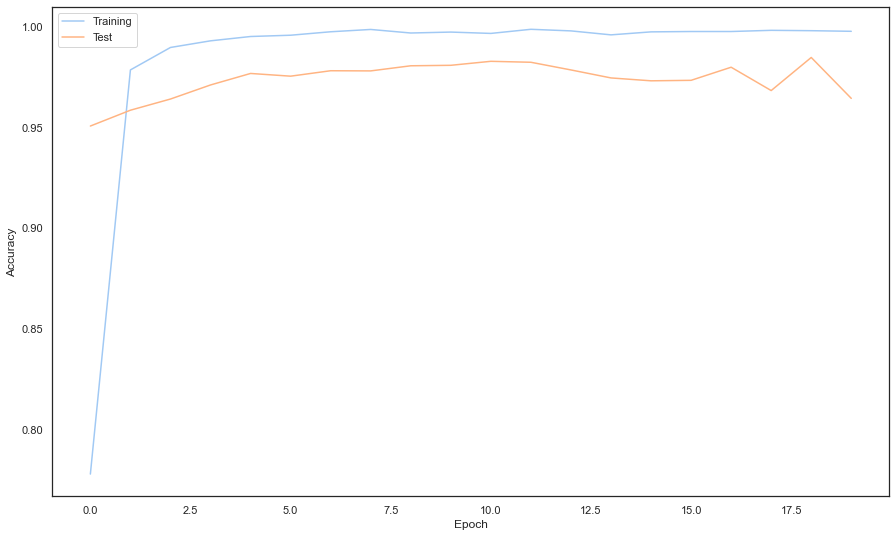

In [112]:
# Setting up parameters
epochs = 20
batch_size = 128
opt_adam = Adam(lr = 0.001)

# Compiling model
model.compile(
    loss = 'categorical_crossentropy', 
    optimizer = opt_adam, 
    metrics = ['accuracy']
);

# Training model
model_history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data = (X_test, y_test))

# Predicting on test data
y_predict = np.argmax(model.predict(X_test), axis=1)

# Checking accuracy on test data
print('\n Test accuracy: ')
print(accuracy_score(np.array(testLabels), y_predict))

# Setting up size of plot and theme
sns.set_theme(style="white", palette="pastel")
plt.figure(figsize=(15,9))

# Plotting accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])

# Setting up labels
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# and legend
plt.legend(['Training', 'Test'], loc='upper left')

plt.show()

#### CNN - 4 conv layer + 2 maxpool + 3 dropout + 2 dense + batchnorm

In [113]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(rate=0.3))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(rate=0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.3))

model.add(Dense(43, activation='softmax'))

model.summary()

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_41 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 conv2d_42 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 batch_normalization_6 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                                 
 dropout_35 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 conv2d_43 (Conv2D)          (None, 12, 12, 64)      

In [114]:
# Setting up parameters
epochs = 20
batch_size = 128
opt_adam = Adam(lr = 0.001)

# Compiling model
model.compile(
    loss = 'categorical_crossentropy', 
    optimizer = opt_adam, 
    metrics = ['accuracy']
);

# Training model
model_history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data = (X_test, y_test))

# Predicting on test data
y_predict = np.argmax(model.predict(X_test), axis=1)

# Checking accuracy on test data
print('\n Test accuracy: ')
print(accuracy_score(np.array(testLabels), y_predict))

# Setting up size of plot and theme
sns.set_theme(style="white", palette="pastel")
plt.figure(figsize=(15,9))

# Plotting accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])

# Setting up labels
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# and legend
plt.legend(['Training', 'Test'], loc='upper left')

plt.show()

Epoch 1/20


C:\Users\PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


307/307 [==============================] - 79s 254ms/step - loss: 0.8710 - accuracy: 0.7843 - val_loss: 0.2356 - val_accuracy: 0.9389
Epoch 2/20
 11/307 [>.............................] - ETA: 1:05 - loss: 0.1338 - accuracy: 0.9673

#### CNN - 4 conv layer + 2 maxpool + 3 dropout + 2 dense + batchnorm + changing parameters

In [ ]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(rate=0.3))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(rate=0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.3))

model.add(Dense(43, activation='softmax'))

model.summary()

In [ ]:
# Setting up parameters
epochs = 20
batch_size = 128
opt_adam = Adam(lr = 0.001)

# Compiling model
model.compile(
    loss = 'categorical_crossentropy', 
    optimizer = opt_adam, 
    metrics = ['accuracy']
);

# Training model
model_history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data = (X_test, y_test))

# Predicting on test data
y_predict = np.argmax(model.predict(X_test), axis=1)

# Checking accuracy on test data
print('\n Test accuracy: ')
print(accuracy_score(np.array(testLabels), y_predict))

# Setting up size of plot and theme
sns.set_theme(style="white", palette="pastel")
plt.figure(figsize=(15,9))

# Plotting accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])

# Setting up labels
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# and legend
plt.legend(['Training', 'Test'], loc='upper left')

plt.show()

#### CNN - 4 conv layer + 2 maxpool + 4 dropout + 2 dense + batchnorm + changing parameters v2

In [ ]:
# CNN architecture
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=64, kernel_size=(4, 4), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(rate=0.3))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(2, 2), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(rate=0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.5))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.2))

model.add(Dense(43, activation='softmax'))

In [ ]:
# Setting up parameters
epochs = 20
batch_size = 128
opt_adam = Adam(lr = 0.001)

# Compiling model
model.compile(
    loss = 'categorical_crossentropy', 
    optimizer = opt_adam, 
    metrics = ['accuracy']
);

# Training model
model_history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data = (X_test, y_test))

# Predicting on test data
y_predict = np.argmax(model.predict(X_test), axis=1)

# Checking accuracy on test data
print('\n Test accuracy: ')
print(accuracy_score(np.array(testLabels), y_predict))

# Setting up size of plot and theme
sns.set_theme(style="white", palette="pastel")
plt.figure(figsize=(15,9))

# Plotting accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])

# Setting up labels
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# and legend
plt.legend(['Training', 'Test'], loc='upper left')

plt.show()

#### CNN - 4 conv layer + 2 maxpool + 4 dropout + 2 dense + batchnorm + changing parameters v3

In [ ]:
# CNN architecture
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(rate=0.3))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(rate=0.2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.5))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.2))

model.add(Dense(43, activation='softmax'))

model.summary()

In [ ]:
# Setting up parameters
epochs = 20
batch_size = 128
opt_adam = Adam(lr = 0.001)

# Compiling model
model.compile(
    loss = 'categorical_crossentropy', 
    optimizer = opt_adam, 
    metrics = ['accuracy']
);

# Training model
model_history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data = (X_test, y_test))

# Predicting on test data
y_predict = np.argmax(model.predict(X_test), axis=1)

# Checking accuracy on test data
print('\n Test accuracy: ')
print(accuracy_score(np.array(testLabels), y_predict))

# Setting up size of plot and theme
sns.set_theme(style="white", palette="pastel")
plt.figure(figsize=(15,9))

# Plotting accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])

# Setting up labels
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# and legend
plt.legend(['Training', 'Test'], loc='upper left')

plt.show()

#### CNN - 4 conv layer + 2 maxpool + 4 dropout + 2 dense + batchnorm + changing learning parameters v4

In [ ]:
# CNN architecture
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(rate=0.3))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(rate=0.2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.5))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.2))

model.add(Dense(43, activation='softmax'))

model.summary()

In [ ]:
# Setting up parameters
epochs = 30
batch_size = 64
opt_adam = Adam(lr = 0.001, decay = 0.001 / (epochs * 0.5))

# Compiling model
model.compile(
    loss = 'categorical_crossentropy', 
    optimizer = opt_adam, 
    metrics = ['accuracy', 'mse']
)

# Training model
model_history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data = (X_test, y_test))

# Predicting on test data
y_predict = np.argmax(model.predict(X_test), axis=1)

# Checking accuracy on test data
print('\n Test accuracy: ')
print(accuracy_score(np.array(testLabels), y_predict))

# Setting up size of plot and theme
sns.set_theme(style="white", palette="pastel")
plt.figure(figsize=(15,9))

# Plotting accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])

# Setting up labels
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# and legend
plt.legend(['Training', 'Test'], loc='upper left')

plt.show()

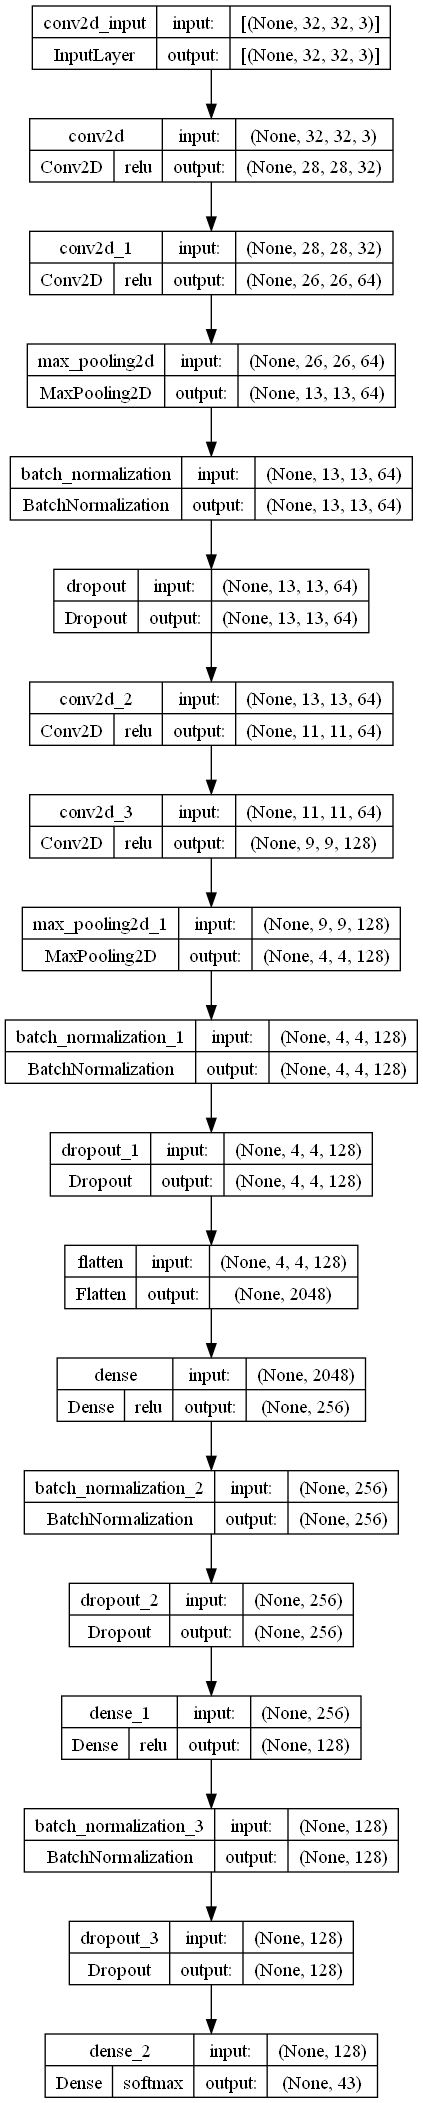

In [20]:
plot_model(model, "MA_thesis_classifier.png", show_shapes=True, show_layer_names=True, show_layer_activations=True)

In [ ]:
epochs = 30
batch_size = 64

opt_adam = Adam(lr = 0.001, decay = 0.001 / (epochs * 0.5))

C:\Users\PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
#Compiling model
model.compile(
    loss = 'categorical_crossentropy', 
    optimizer = opt_adam, 
    metrics = ['accuracy', 'mse']
)

In [23]:
# Training model
model_history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/30
613/613 [==============================] - 73s 116ms/step - loss: 0.8441 - accuracy: 0.7841 - mse: 0.0067
Epoch 2/30
613/613 [==============================] - 86s 141ms/step - loss: 0.1006 - accuracy: 0.9742 - mse: 9.6804e-04
Epoch 3/30
613/613 [==============================] - 97s 158ms/step - loss: 0.0599 - accuracy: 0.9832 - mse: 5.9660e-04
Epoch 4/30
613/613 [==============================] - 69s 112ms/step - loss: 0.0426 - accuracy: 0.9878 - mse: 4.3500e-04
Epoch 5/30
613/613 [==============================] - 67s 109ms/step - loss: 0.0325 - accuracy: 0.9905 - mse: 3.3934e-04
Epoch 6/30
613/613 [==============================] - 67s 109ms/step - loss: 0.0287 - accuracy: 0.9920 - mse: 2.9984e-04
Epoch 7/30
613/613 [==============================] - 68s 111ms/step - loss: 0.0234 - accuracy: 0.9932 - mse: 2.4979e-04
Epoch 8/30
613/613 [==============================] - 74s 120ms/step - loss: 0.0236 - accuracy: 0.9928 - mse: 2.5410e-04
Epoch 9/30
613/613 [================

In [24]:
# Predicting on test data
y_predict = np.argmax(model.predict(X_test), axis=1)

# Checking accuracy on test data
accuracy_score(np.array(testLabels), y_predict)

395/395 [==============================] - 6s 14ms/step


0.9877276326207443

# Model with augmentations

In [ ]:
# Applying augmentation methods to train data # TO DO
dataaug = ImageDataGenerator(
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    rotation_range = 15,
    zoom_range = 0.10,
    fill_mode = "nearest")

(32, 3)
(32, 3)
(32, 3)
(32, 3)
(32, 3)
(32, 3)


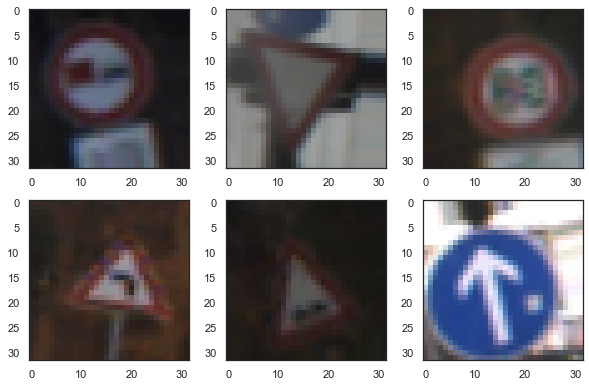

In [113]:
# Visualizing some augmented images

# Setting size of figure
plt.figure(figsize=(10,10))

# Setting up seed for replicability
random.seed(1)

# Loop for creating figure with images
for i in range(1,7):
    
    # Creating subplots for 10 images
    plt.subplot(3,3,i)

    # Getting random image and augmenting it
    aug_iter = dataaug.flow(X_train, batch_size=1)
    image_aug = next(aug_iter)[0].astype('uint8')
    # Plotting images
    plt.imshow(image_aug)

# Saving image to jpg
#plt.savefig('Images_augmented.jpg', bbox_inches='tight')

In [ ]:
# Training model
pre_model_history = model.fit(dataaug.flow(X_train, y_train, batch_size=batch_size), epochs=epochs, 
                               validation_data = (X_test, y_test),
                               callbacks = [ModelCheckpoint('MA_thesis_classifier.h5', save_best_only=True)]
                               )

Epoch 1/30
613/613 [==============================] - 79s 128ms/step - loss: 0.3363 - accuracy: 0.9179 - mse: 0.0029 - val_loss: 0.0375 - val_accuracy: 0.9904 - val_mse: 3.5170e-04
Epoch 2/30
613/613 [==============================] - 79s 129ms/step - loss: 0.1351 - accuracy: 0.9607 - mse: 0.0014 - val_loss: 0.0334 - val_accuracy: 0.9895 - val_mse: 3.6404e-04
Epoch 3/30
613/613 [==============================] - 78s 127ms/step - loss: 0.1001 - accuracy: 0.9702 - mse: 0.0010 - val_loss: 0.0416 - val_accuracy: 0.9892 - val_mse: 3.8033e-04
Epoch 4/30
613/613 [==============================] - 77s 126ms/step - loss: 0.0716 - accuracy: 0.9782 - mse: 7.6735e-04 - val_loss: 0.0481 - val_accuracy: 0.9866 - val_mse: 4.7584e-04
Epoch 5/30
613/613 [==============================] - 81s 132ms/step - loss: 0.0673 - accuracy: 0.9804 - mse: 6.9676e-04 - val_loss: 0.0377 - val_accuracy: 0.9888 - val_mse: 3.9193e-04
Epoch 6/30
613/613 [==============================] - 83s 135ms/step - loss: 0.0558 - a

In [29]:
# Saving model
# model.save('MA_thesis_classifier.h5')

In [12]:
# Loading model
#model = keras.models.load_model('MA_thesis_classifier.h5')

In [13]:
# Predicting on test data
pre_y_predict = np.argmax(model.predict(X_test), axis=1)

# Checking accuracy on test data
accuracy_score(np.array(testLabels), pre_y_predict)

395/395 [==============================] - 5s 12ms/step


0.9902612826603325

In [14]:
# Creating detailed classification report
print(classification_report(testLabels.tolist(), pre_y_predict.tolist()))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94        60
           1       0.98      1.00      0.99       720
           2       1.00      0.99      1.00       750
           3       1.00      0.98      0.99       450
           4       1.00      0.97      0.99       660
           5       0.98      1.00      0.99       630
           6       0.99      0.99      0.99       150
           7       1.00      1.00      1.00       450
           8       1.00      1.00      1.00       450
           9       0.99      1.00      1.00       480
          10       1.00      1.00      1.00       660
          11       0.99      0.98      0.98       420
          12       1.00      0.98      0.99       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       0.98      1.00      0.99       210
          16       1.00      1.00      1.00       150
          17       1.00    

In [15]:
# Saving classification report to csv
report = classification_report(testLabels.tolist(), pre_y_predict.tolist(), output_dict=True)
classification_results= pd.DataFrame(report).transpose()
#classification_results.to_csv('classification_report.csv')

# Plotting results


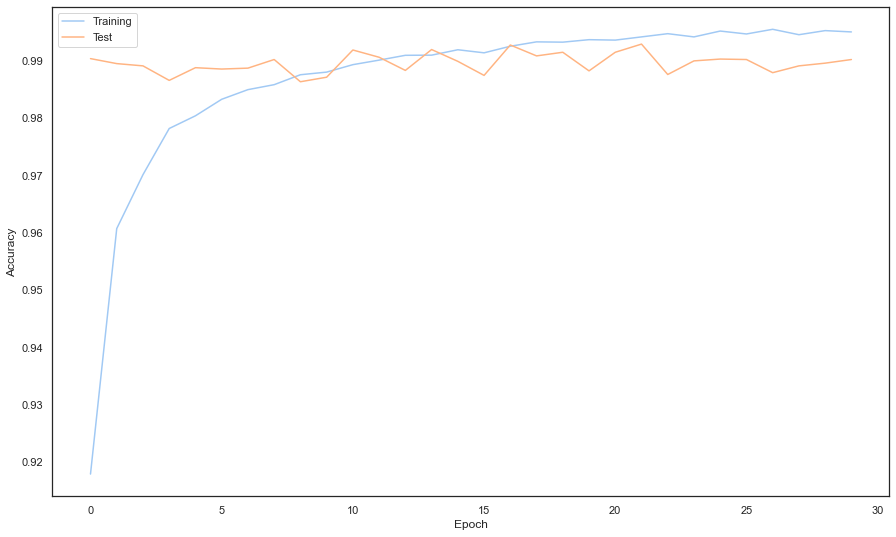

In [30]:
# Setting up size of plot and theme
sns.set_theme(style="white", palette="pastel")
plt.figure(figsize=(15,9))

# Plotting accuracy
plt.plot(pre_model_history.history['accuracy'])
plt.plot(pre_model_history.history['val_accuracy'])

# Setting up labels
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# and legend
plt.legend(['Training', 'Test'], loc='upper left')

plt.show()

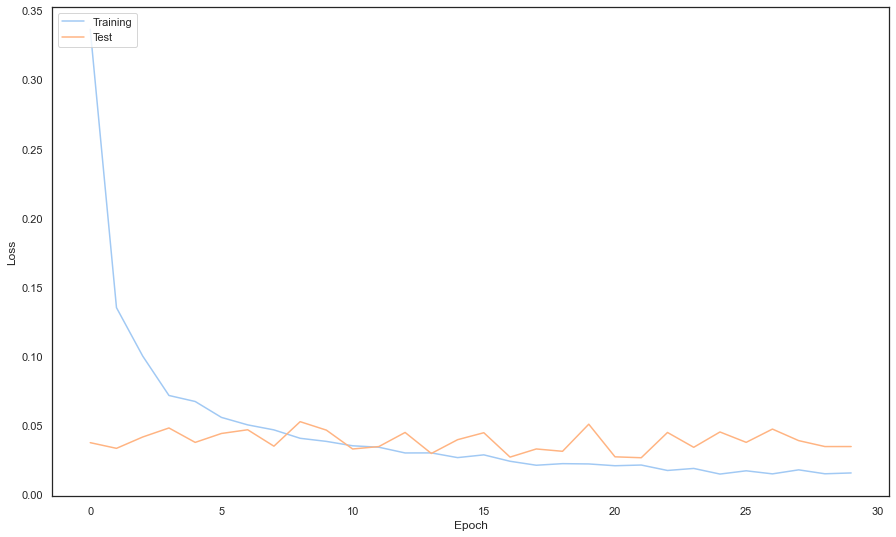

In [31]:
# Setting up size of plot and theme
sns.set_theme(style="white", palette="pastel")
plt.figure(figsize=(15,9))

# Plotting accuracy
plt.plot(pre_model_history.history['loss'])
plt.plot(pre_model_history.history['val_loss'])

# Setting up labels
plt.xlabel('Epoch')
plt.ylabel('Loss')

# and legend
plt.legend(['Training', 'Test'], loc='upper left')

plt.show()

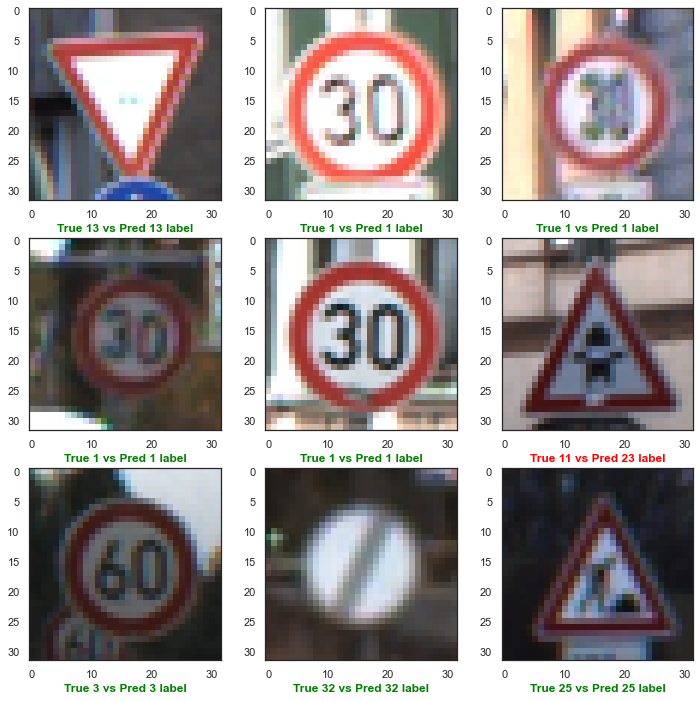

In [131]:
# Visualizing predicted labels vs true labels

# Setting size of figure
plt.figure(figsize=(12,12))

# Setting up seed for replicability
random.seed(16)

# Loop for creating figure with images
for i in range(1,10):
    
    # Creating subplots for 10 images
    plt.subplot(3,3,i)

    # Choosing random number
    number = random.randint(0,12630)

    # Getting random image and coresponding label + predicted label
    image = X_test[number]
    pred_label = pre_y_predict[number]
    true_label = testLabels[number]

    # If labels dont match, display red color
    if pred_label == true_label:
            x = 'green'
    else:
            x = 'red'

    # Plotting images and labels
    plt.imshow(image)
    plt.xlabel("True {} vs Pred {} label".format(true_label, pred_label), 
               fontweight='bold',
               color = x)

# Saving image to jpg
#plt.savefig('Images_vis.jpg', bbox_inches='tight')

In [16]:
# Getting only misclassified images and their labels

# Preparing lists
misclassified_images = []
misclassified_labels = []
right_labels = []

# Loop for getting wrong labels and corresponding images
for i in range(len(pre_y_predict)) :
  if pre_y_predict[i] != testLabels[i] :
    misclassified_images.append(testImages[i])
    misclassified_labels.append(pre_y_predict[i])
    right_labels.append(testLabels[i])

print("{}/{} images are misclassified. That is around {:.2f}% of all images".format(len(misclassified_labels), testLabels.shape[0], len(misclassified_labels)/testLabels.shape[0]*100))

123/12630 images are misclassified. That is around 0.97% of all images


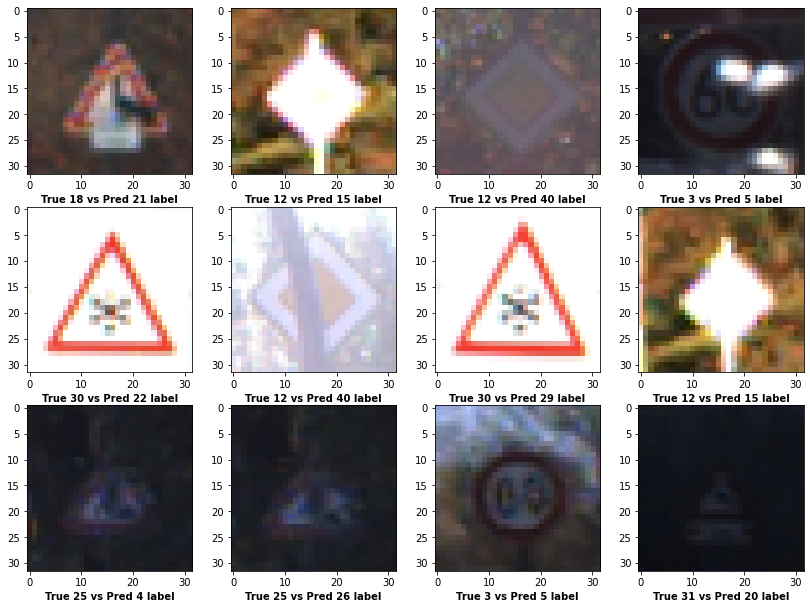

In [17]:
# Visualizing misclassified images

# Setting size of figure
plt.figure(figsize=(14,14))

# Setting up seed for replicability
random.seed(2)

# Loop for creating figure with images
for i in range(1,13):
    
    # Creating subplots for 10 images
    plt.subplot(4,4,i)

    # Choosing random number
    number = random.randint(0,123)

    # Getting random image and coresponding label + predicted label
    image = misclassified_images[number]
    pred_label = misclassified_labels[number]
    true_label = right_labels[number]

    # Plotting images and labels
    plt.imshow(image)
    plt.xlabel("True {} vs Pred {} label".format(true_label, pred_label), 
               fontweight='bold')

# Saving image to jpg
#plt.savefig('Images_vis.jpg', bbox_inches='tight')

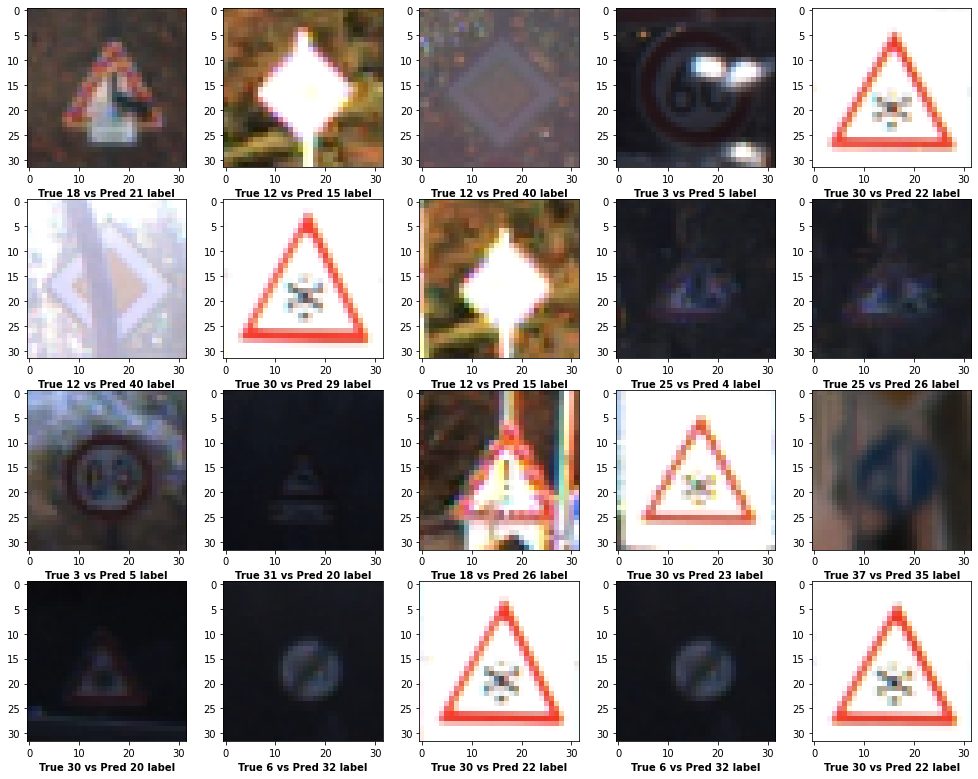

In [25]:
# Visualizing misclassified images

# Setting size of figure
plt.figure(figsize=(17,17))

# Setting up seed for replicability
random.seed(2)

# Loop for creating figure with images
for i in range(1,21):
    
    # Creating subplots for 10 images
    plt.subplot(5,5,i)

    # Choosing random number
    number = random.randint(0,123)

    # Getting random image and coresponding label + predicted label
    image = misclassified_images[number]
    pred_label = misclassified_labels[number]
    true_label = right_labels[number]

    # Plotting images and labels
    plt.imshow(image)
    plt.xlabel("True {} vs Pred {} label".format(true_label, pred_label), 
               fontweight='bold')

# Saving image to jpg
#plt.savefig('Images_vis.jpg', bbox_inches='tight')

In [24]:
# Count missclassified images for each label 
count_classes = Counter(misclassified_labels)
count_classes

Counter({27: 4,
         25: 4,
         36: 2,
         1: 18,
         22: 4,
         0: 8,
         26: 10,
         30: 5,
         29: 5,
         40: 5,
         15: 5,
         23: 12,
         5: 10,
         20: 3,
         3: 2,
         9: 3,
         18: 1,
         2: 2,
         21: 3,
         37: 1,
         6: 1,
         13: 2,
         35: 3,
         11: 6,
         8: 1,
         32: 1,
         4: 1,
         28: 1})

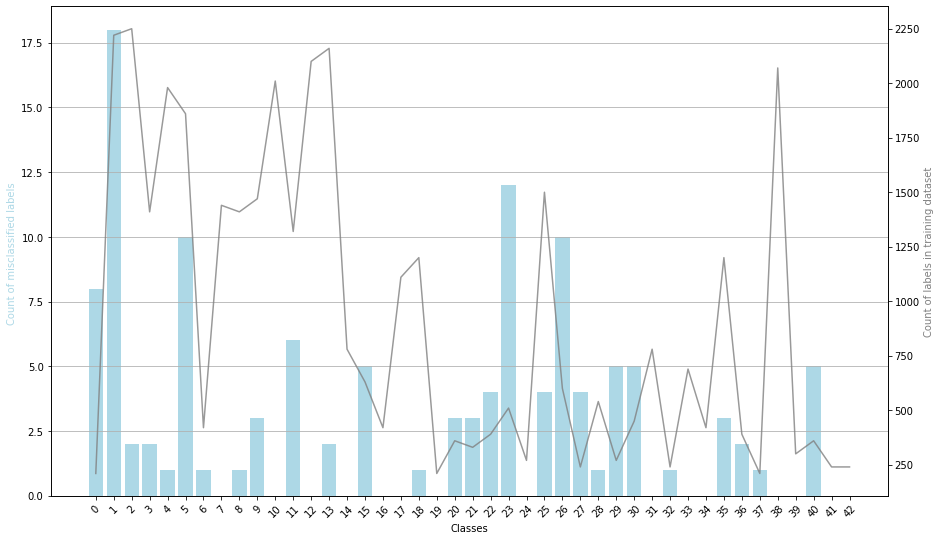

In [23]:
# Comparison of misclassified images vs number of images in training dataset

# Setting up theme and grid look
plt.figure(figsize=(15,9))
plt.grid(axis='y')

# Plotting count of misclassified labels 
plt.bar(count_classes.keys(), count_classes.values(), color='lightblue')

# adding labels and legend
plt.ylabel('Count of misclassified labels ', color='lightblue')
plt.xlabel('Classes')
plt.xticks(unique_classes_train, rotation=45)

# Adding second y axis
plt.twinx()

# Plotting count of labels in training dataset
plt.plot(unique_classes_train,classes_counts_train, color='grey', alpha=0.8)
plt.ylabel('Count of labels in training dataset', color='grey')

plt.show()

In [84]:
# Adding 0 value classes
count_classes[7] = 0
count_classes[10] = 0
count_classes[12] = 0
count_classes[14] = 0
count_classes[16] = 0
count_classes[17] = 0
count_classes[19] = 0
count_classes[24] = 0
count_classes[31] = 0
count_classes[33] = 0
count_classes[34] = 0
count_classes[38] = 0
count_classes[39] = 0
count_classes[41] = 0
count_classes[42] = 0

# Ordering dictionary
count_classes_ordered = OrderedDict(sorted(count_classes.items()))

# Saving into pandas dataframe
count_classes_pd = pd.DataFrame(count_classes_ordered.items(), columns=['Class', 'Misclassified_img'])

# Adding support column to dataframe
count_classes_pd = count_classes_pd.assign(Support = list(classification_results['support'][0:43]))

# Calculating percentage of misclassified images
count_classes_pd = count_classes_pd.assign(Percent_of_misclassified_img=lambda x: round(x.Misclassified_img / x.Support * 100, 2))


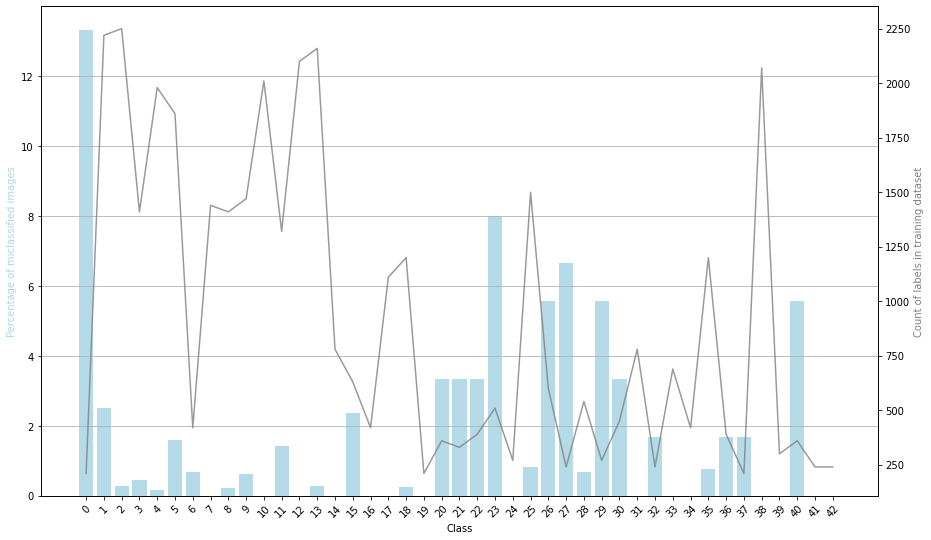

In [103]:
# Different size of images in train set

# Setting up theme and grid look
plt.figure(figsize=(15,9))
plt.grid(axis='y')

# Plotting barplot 
plt.bar(count_classes_pd["Class"], count_classes_pd["Percent_of_misclassified_img"], color='lightblue', alpha=0.9, label='Height')

# Adding ticks
plt.xticks(count_classes_pd["Class"], rotation=45)

# adding labels and legend
plt.xlabel('Class')
plt.ylabel('Percentage of miclassified images', color='lightblue')

# Adding second y axis
plt.twinx()

# Plotting count of labels in training dataset
plt.plot(unique_classes_train,classes_counts_train, color='grey', alpha=0.8)
plt.ylabel('Count of labels in training dataset', color='grey')

plt.show()